In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, metrics
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
import random
from sklearn.dummy import DummyClassifier
from scipy import stats
import math
from skimage import morphology, img_as_ubyte
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path_to_data = "gdrive/My Drive/data/train_images.npy"
path_to_labels = "gdrive/My Drive/data/train_labels.csv"
path_to_test = "gdrive/My Drive/data/test_images.npy"

# path_broad = "gdrive/My Drive/Mcgill/U4/Fall 2018/COMP 551/kaggle/data/"
# path_to_data = path_broad + "train_images.npy"
# path_to_labels = path_broad + "train_labels.csv"
# path_to_test = path_broad + "test_images.npy"

In [0]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(20, max_col * r))
        for i, (img,name) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title(str(name))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

In [0]:
def get_data(path_x, path_y):
    data = np.load(path_x, encoding = 'bytes')
    labels_df = pd.read_csv(path_y)
    labels_df.Category = pd.Categorical(labels_df.Category)
    y = labels_df.Category.cat.codes.values
    X = np.array(data[:, 1])
    X_actual = np.array(data[:, 1])
    for c, i in enumerate(X):
        ret,thresh_img = cv2.threshold(i,127,255,cv2.THRESH_BINARY)
        X[c] = thresh_img
    return X, y, X_actual

In [0]:
X_noisy, y, X_noisy_actual = get_data(path_to_data, path_to_labels)
print("Shape of training dataset:", len(X_noisy))
X_test = list(np.load(path_to_test, encoding = 'bytes')[:, 1])
print("Shape of testing dataset:", len(X_test))
unique_classes = set(y)
print("Number of classes:", len(unique_classes))

Shape of training dataset: 10000
Shape of testing dataset: 10000
Number of classes: 31


In [0]:
from scipy import ndimage

def remove_noise(filledImg, min_size = 500):
    min_blobs, min_val = ndimage.label(filledImg)
    
    for i in range(10,60):
        clean_img = morphology.remove_small_objects(img_as_bool(filledImg), i)
        blobs, number_of_blobs = ndimage.label(clean_img)
        if number_of_blobs < min_val:
            min_val = number_of_blobs
            if min_val == 1:
                return clean_img
  
    return clean_img

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


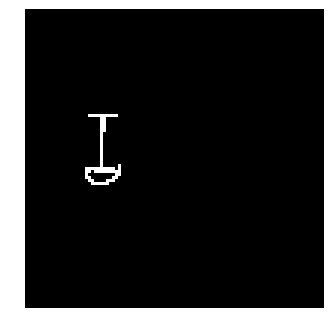

In [0]:
X = []
for c, (img, label) in enumerate(zip(X_noisy, y)):
    img = img.reshape(100, 100)
    X.append(remove_noise(img, 100).flatten()) 
    
test= X[0]
test.resize(100,100)
plot_images(np.array([test]))

In [0]:
for c, img in enumerate(X):
    X[c] = np.array(img)
X = np.array(X)

In [0]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]
  
def pad_image(img, pad_t, pad_r, pad_b, pad_l):
    """Add padding of zeroes to an image.
    Add padding to an array image.
    :param img:
    :param pad_t:
    :param pad_r:
    :param pad_b:
    :param pad_l:
    """
    height, width = img.shape

    # Adding padding to the left side.
    pad_left = np.zeros((height, pad_l), dtype = np.int)
    img = np.concatenate((pad_left, img), axis = 1)

    # Adding padding to the top.
    pad_up = np.zeros((pad_t, pad_l + width))
    img = np.concatenate((pad_up, img), axis = 0)

    # Adding padding to the right.
    pad_right = np.zeros((height + pad_t, pad_r))
    img = np.concatenate((img, pad_right), axis = 1)

    # Adding padding to the bottom
    pad_bottom = np.zeros((pad_b, pad_l + width + pad_r))
    img = np.concatenate((img, pad_bottom), axis = 0)

    return img

def center_image(X_array, X_noise, show_image=False):
  """Return a centered image.
  :param img:
  """
  cropped = []
  for i in range(len(X_array)):
    img = X_array[i].copy()
    img.resize(100,100)
    
    img_noise = X_noise[i].copy()
    img_noise.resize(100,100)

    blobs, min_val = ndimage.label(img)
    unique, counts = np.unique(blobs, return_counts=True)
    if len(unique) > 1:
      id = np.argpartition(counts.flatten(), -2)[-2]
      img[blobs != id] = 0    
       
        
    if show_image:
      print('actual')
      plot_images(np.array([img_noise]))
      print('denoised')
      plot_images(np.array([img]))
      
#     cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
#     y1, y2 = cropBox[0], cropBox[1]
#     x1, x2 = cropBox[2], cropBox[3]
#     cropped_image = img[y1:y2, x1:x2]

    col_sum = np.where(np.sum(img, axis=0) > 0)
    row_sum = np.where(np.sum(img, axis=1) > 0)
    if len(row_sum[0]) == 0:
      y1, y2 = 0, 0
 
    else:
      y1, y2 = row_sum[0][0]-5, row_sum[0][-1]+5
      if y1 < 0:
        y1 = 0
      if y2 > img.shape[0]:
        y2 = img.shape[0]-1
    
    if len(col_sum[0]) == 0:
      x1, x2 = 0, 0 
    else:
      x1, x2 = col_sum[0][0]-5, col_sum[0][-1]+5
      if x1 < 0:
        x1 = 0
      if x2 >= img.shape[1]:
        x2 = img.shape[1]-1

    cropped_image = img_noise[y1:y2, x1:x2]
    cropped_denoised = img[y1:y2, x1:x2]
    zero_axis_fill = (img.shape[0] - cropped_image.shape[0])
    one_axis_fill = (img.shape[1] - cropped_image.shape[1])

    top = zero_axis_fill // 2
    bottom = zero_axis_fill - top
    left = one_axis_fill // 2
    right = one_axis_fill - left

    padded_image = pad_image(cropped_image, top, left, bottom, right)
    padded_denoised = pad_image(cropped_denoised, top, left, bottom, right)
    cropped_image = crop_center(padded_image, 40, 40)
    cropped_denoised = crop_center(padded_denoised, 40, 40)
    if show_image:
      print('cropped actual')
      plot_images(np.array([cropped_image]))
      print('cropped denoised')
      plot_images(np.array([cropped_denoised]))

    cropped.append(np.array(cropped_image.flatten()))
    
    

  cropped = np.array(cropped)
  
  return cropped

X_cropped = center_image(X, X_noisy_actual, show_image=False)

In [0]:
# X_cropped = crop_image(X, size_of_crop=32)
unique, counts = np.unique(y[:9488], return_counts=True)

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
num_classes = 31
epochs = 40

# input image dimensions
img_rows, img_cols = 40, 40
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X_cropped[:9488],y[:9488]), (X_cropped[9488:],y[9488:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')


x_train /= 255
x_val /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train[3])
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# optimizer = keras.optimizers.Nadam(lr=0.002,
#                   beta_1=0.9,
#                   beta_2=0.999,
#                   epsilon=1e-08,
#                   schedule_decay=0.004)

optimizer = keras.optimizers.Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=None,
                  schedule_decay=0.004)

# Set our optimizer and loss function (similar settings to our CAE approach)
model.compile(loss = keras.losses.categorical_crossentropy,
            optimizer = optimizer,
            metrics = ['categorical_accuracy'])

checkpoint = ModelCheckpoint('best.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                      factor=0.1, patience=5,
                      min_delta=0.0001, mode='auto',
                      cooldown=0, verbose=1, 
                      min_lr=0),
    checkpoint
]
model.fit_generator(train_generator,
          steps_per_epoch= 14000 // batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(x_val, y_val),
          callbacks = callbacks,
          )


score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (9488, 40, 40, 1)
9488 train samples
512 val samples
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/40
218/218 [==============================] - 19s 85ms/step - loss: 3.3235 - categorical_accuracy: 0.0717 - val_loss: 3.0211 - val_categorical_accuracy: 0.0977

Epoch 00001: val_categorical_accuracy improved from -inf to 0.09766, saving model to best.hdf5
Epoch 2/40
218/218 [==============================] - 10s 44ms/step - loss: 2.7286 - categorical_accuracy: 0.2065 - val_loss: 2.1108 - val_categorical_accuracy: 0.3594

Epoch 00002: val_categorical_accuracy improved from 0.09766 to 0.35938, saving model to best.hdf5
Epoch 3/40
218/218 [==============================] - 10s 44ms/step - loss: 2.2773 - categorical_accuracy: 0.3291 - val_loss: 1.7015 - val_categorical_accuracy: 0.5039

Epoch 00003: val_categorical_accuracy improved from 0.35938 to 0.50391, saving model to best.hdf5
Epoch 4/40
218/218 [==================

In [0]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)
  
  
batch_size = 64
num_classes = 31
epochs = 100

# input image dimensions
img_rows, img_cols = 40, 40
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X_cropped[:9488],y[:9488]), (X_cropped[9488:],y[9488:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

x_train /= 255
x_val /= 244

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train[3])
datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

model_mn = MobileNet(input_shape=(img_rows, img_cols, 1), alpha=1., weights=None, classes=num_classes)
model_mn.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])



callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]

hist = model_mn.fit_generator(
    train_generator, steps_per_epoch= 14000 // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks
)

score = model_mn.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (9488, 40, 40, 1)
9488 train samples
512 val samples
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/100
218/218 [==============================] - 27s 122ms/step - loss: 3.2501 - categorical_crossentropy: 3.2501 - categorical_accuracy: 0.1277 - top_3_accuracy: 0.2977 - val_loss: 3.4903 - val_categorical_crossentropy: 3.4903 - val_categorical_accuracy: 0.0293 - val_top_3_accuracy: 0.1191
Epoch 2/100
218/218 [==============================] - 18s 81ms/step - loss: 2.8529 - categorical_crossentropy: 2.8529 - categorical_accuracy: 0.1927 - top_3_accuracy: 0.4261 - val_loss: 3.5729 - val_categorical_crossentropy: 3.5729 - val_categorical_accuracy: 0.0488 - val_top_3_accuracy: 0.1328
Epoch 3/100
218/218 [==============================] - 18s 81ms/step - loss: 2.6641 - categorical_crossentropy: 2.6641 - categorical_accuracy: 0.2436 - top_3_accuracy: 0.5031 - val_loss: 3.7969 - val_categorical_crossentropy: 3.7969 - val_ca

In [0]:
model_cnn = model

In [0]:
test = []
for c, img in enumerate(X_test):
    img = img.reshape(100, 100)
    test.append(remove_noise(img, 100).flatten())
    
for c, img in enumerate(test):
    test[c] = np.array(img)
test = np.array(test)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
X_test_cropped = center_image(test, X_test, show_image=False)

In [0]:
test_x = X_test_cropped
if K.image_data_format() == 'channels_first':
    test_x = test_x.reshape(test_x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
test_x = test_x.astype('float32')
test_x /= 255

In [0]:
prediction_mn = model_mn.predict(test_x, batch_size=1, verbose=1)
prediction_cnn = model_cnn.predict(test_x, batch_size=1, verbose=1)

10000/10000 [==============================] - 68s 7ms/step


In [0]:
sum_ = prediction_cnn + prediction_mn
sum_ = np.argmax(sum_,axis=1)

In [0]:
labels_df = pd.read_csv(path_to_labels)
labels_df.Category = pd.Categorical(labels_df.Category)
cat_map = pd.Categorical(labels_df.Category)
cat_map = cat_map.categories
result_sum = []
for index, image in enumerate(sum_):
  result_sum.append(cat_map[image])
  
result_sum = pd.DataFrame(result_sum)
result_sum = result_sum.reset_index(drop=False)
result_sum.columns=['Id', 'Category']
result_sum.to_csv('result_sum.csv', index=False)

In [0]:
import pandas as pd
result_cnn, result_mn = [], []
labels_df = pd.read_csv(path_to_labels)
labels_df.Category = pd.Categorical(labels_df.Category)
cat_map = pd.Categorical(labels_df.Category)
cat_map = cat_map.categories

cnn_expected = np.argmax(prediction_cnn,axis=1)
mn_expected = np.argmax(prediction_mn,axis=1)

for index, image in enumerate(cnn_expected):
  result_cnn.append(cat_map[image])

result_cnn = pd.DataFrame(result_cnn)
result_cnn = result_cnn.reset_index(drop=False)
result_cnn.columns=['Id', 'Category']
result_cnn.to_csv('result_cnn.csv', index=False)



for index, image in enumerate(mn_expected):
  result_mn.append(cat_map[image])
  
result_mn = pd.DataFrame(result_mn)
result_mn = result_mn.reset_index(drop=False)
result_mn.columns=['Id', 'Category']
result_mn.to_csv('result_mn.csv', index=False)